<a href="https://colab.research.google.com/github/musashiCZX/keras/blob/master/A3_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Deep Learning
## Assignment 3
### Task 1: Recurrent Neural Networks
<img src="https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg" width="500"> 

The goal of this task is to learn how to use encoder-decoder recurrent models. Specifically we will be dealing with a sequence to sequence problem and try to develop a neural network that can learn the principles behind simple arithmetic operations.



To work on this notebook you should create a copy of it.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

# Function definitions for creating the dataset

In order to create image queries of simple arithmetic operations such as '51+31' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset.

In [ ]:
# Create plus/minus signs
def generate_images(cross=False, n=50):
    x = np.random.randint(12, 16, (n, 2))
    y1 = np.random.randint(4, 8, n)
    y2 = np.random.randint(20, 24, n)
    
    blank = np.zeros([n, 28, 28])
    for i in range(n):
        line = cv2.line(blank[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)
        if cross:
            line = cv2.line(blank[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank

def show_generated(images):
    for i in range(20):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(cross=True))

In [ ]:
import random

def create_data(highest_integer):
    """
    Creates the following data for all pairs of integers up to [highest integer]+[highest_integer]:

    @return:
    X_text: '151+ 21' -> text query of an arithmetic operation
    X_img : Stack of MNIST images corresponding to the query (7 x 28 x 28)
    y_text: ' 172' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (4 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(cross=True)
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []
    for i in range(highest_integer + 1):
        for j in range(highest_integer + 1):
            
            i_char = to_padded_chars(i, max_len=max_int_length)
            j_char = to_padded_chars(j, max_len=max_int_length)

            for sign in ['-', '+']:
                query_string = i_char + sign + j_char
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))
            
    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.
  
def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 80000 samples that have two kinds of inputs and labels:

  X_text: strings containing queries of length 7: ['  1+  1', '174- 18', ...] 

  X_image: a stack of images representing a single query, dimensions: [7, 28, 28]

  y_text: strings containing answers of length 4: ['   2', ' 156']

  y_image: a stack of images that represents the answer to a query, dimensions: [4, 28, 28]

(80000,) (80000, 7, 28, 28) (80000,) (80000, 4, 28, 28)
Sample ID: 20921

X_text: " 52+ 60" = y_text: " 112"


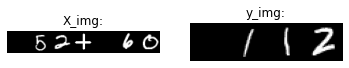

Sample ID: 24069

X_text: " 60+ 34" = y_text: "  94"


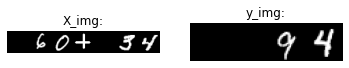

Sample ID: 25089

X_text: " 62+144" = y_text: " 206"


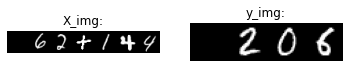

Sample ID: 53244

X_text: "133- 22" = y_text: " 111"


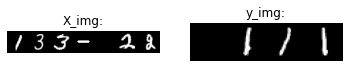

Sample ID: 64251

X_text: "160+125" = y_text: " 285"


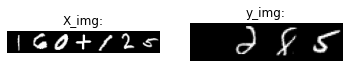

Sample ID: 18523

X_text: " 46+ 61" = y_text: " 107"


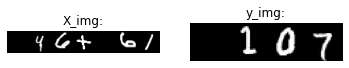

Sample ID: 6912

X_text: " 17- 56" = y_text: " -39"


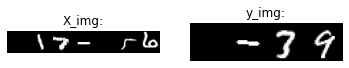

Sample ID: 4203

X_text: " 10+101" = y_text: " 111"


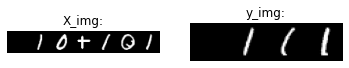

Sample ID: 36161

X_text: " 90+ 80" = y_text: " 170"


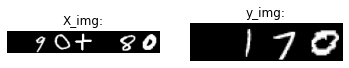

Sample ID: 11302

X_text: " 28- 51" = y_text: " -23"


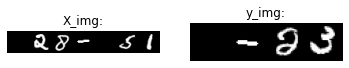

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- ' # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 199 # Highest value of integers contained in the queries
max_int_length = len(str(highest_integer)) # 
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = max_int_length + 1    # Maximum length of the answer string

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labs = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        plt.axis('off')
        plt.title(labs[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nSample ID: {n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 80000, 1)[0])

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=4):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot 

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(80000, 7, 13) (80000, 4, 13)


---
---

# 1. Text-to-text RNN model

The following code showcases how Recurrent neural networks are built using Keras. Several new layers are going to be used:

1. LSTM 
2. TimeDistributed
3. RepeatVector

The following code shows the basic architecture of a Recurrent Neural Network that usees
LSTM (Long Short Term Memory) layers which can be replaced either with SimpleRNN or GRU (Gated Recurrent Units).



<img src="https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg" width="500"> 


In [ ]:
# We start by initializing a sequential model
text2text = tf.keras.Sequential()

# "Encode" the input sequence using an RNN, producing an output of size 256.
# In this case the size of our input vectors is [7, 13] as we have queries of length 7 and 13 unique characters. Each of these 7 elements in the query will be fed to the network one by one,
# as shown in the image above (except with 7 elements).
# Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
text2text.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))

# As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 4 times as that's the maximum length of the output (e.g. '  1-199' = '-198')
# when using 3-digit integers in queries. In other words, the RNN will always produce 4 characters as its output.
text2text.add(RepeatVector(max_answer_length))

# By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
# the first dimension to be the timesteps.
text2text.add(LSTM(128, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

# Next we compile the model using categorical crossentropy as our loss function.
text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
text2text.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               276480    
                                                                 
 repeat_vector (RepeatVector  (None, 4, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 4, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 4, 13)            1677      
 ibuted)                                                         
                                                                 
Total params: 475,277
Trainable params: 475,277
Non-trainable params: 0
_________________________________________________________________


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               276480    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 128)            197120    
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 13)             1677      
Total params: 475,277
Trainable params: 475,277
Non-trainable params: 0
_________________________________________________________________


### Your tasks:


In [ ]:
# Train and experiment with the text-to-text RNN Model by using X_text and y_text as your inputs/outputs
# 1. Try different ratios of train/test splits
# 2. Try to find more optimal architectures





---
---

# 2. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use X_img as inputs and y_text as outputs.

In [ ]:
# Your code






---
---

# 3. Text to image RNN Model

Hint: to make this model work well you will need deconvolutional layers in your decoder (look up ***Conv2DTranspose*** layer). To connect this from a flat latent vector you will also need an operation which is opposite to a ***Flatten*** layer that you usually use in convolutional architectures - for this look up the ***Reshape*** layer.

The goal here is to use X_text as inputs and y_img as outputs.

In [ ]:
# Your code




